In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import glob
from PIL import Image
import gc
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import cv2
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from collections import defaultdict
from ultralytics import YOLO

In [27]:
class ImageClassifierDetector:
    def __init__(self, yolo_models, img_path, threshold):
        self.yolo_models = yolo_models
        self.img_path = img_path
        self.threshold = threshold
        self.dn=0
        self.rs=0

    def make_predictions(self, model):
        image = image_utils.load_img(self.img_path, target_size=(224, 224))
        image = image_utils.img_to_array(image)
        image = image.reshape(1,224,224,3)
        image = preprocess_input(image)
        preds = model.predict(image)
        return preds

    def contains_text(self, image, x1, y1):
        # Define the area where the text would be drawn
        text_width, text_height = 100, 30  # Assumed size of the text area
        y_start = max(0, int(y1) - text_height)
        y_end = int(y1)
        x_start = int(x1)
        x_end = int(x1) + text_width

        # Extract the region of interest (ROI)
        roi = image[y_start:y_end, x_start:x_end]

        # Define the green color range
        lower_green = np.array([0, 255, 0])
        upper_green = np.array([0, 255, 0])

        # Create a mask for green color
        mask = cv2.inRange(roi, lower_green, upper_green)

        # Check if there are any green pixels in the ROI
        green_pixels = cv2.countNonZero(mask)

        # Heuristic: if there are green pixels, assume the region contains text
        if green_pixels > 0:
            return True
        return False

    def draw_boxes(self, image, mp):
        for class_name, values in mp.items():
            print(class_name, values)
            for value in values:
                x1, y1, x2, y2, score = value
                if score >= self.threshold:
                    if not self.contains_text(image,x1,y1-10):
                        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
                        cv2.putText(image, class_name.upper(), (int(x1), int(y1 - 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    def make_boxes(self, models):
        image = cv2.imread(self.img_path)
        mp = defaultdict(list)
        for model in models:
            results = model(self.img_path)[0]
            z = []
            for result in results.boxes.data.tolist():
                x1, y1, x2, y2, score, class_id = result
                class_name = results.names[int(class_id)].lower()
                if(len(mp[class_name]) != 0):
                    v = mp[class_name]
                    if abs(v[-1][0] - x1) >= 6 and abs(v[-1][1] - y1) >= 6 and abs(v[-1][2] - x2) >= 6 and abs(v[-1][3]- y2)>=6:
                        mp[class_name].append([x1,y1,x2,y2,score])
                else:
                    mp[class_name].append([x1,y1,x2,y2,score])
        self.draw_boxes(image, mp)
        # Convert the image from BGR to RGB for displaying
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    def run_tf(self):
        model_day_night = tf.keras.models.load_model("/content/drive/MyDrive/juvdv2-vdvwc/IC_Models/day_night.h5")
        model_rainny_sunny = tf.keras.models.load_model("/content/drive/MyDrive/juvdv2-vdvwc/IC_Models/rainny_sunny.h5")
        dn = np.argmax(self.make_predictions(model_day_night))
        rs = np.argmax(self.make_predictions(model_rainny_sunny))
        print(dn , rs)
        self.dn = dn
        self.rs = rs

    def run(self):
        print(self.dn + self.rs)
        self.make_boxes([self.yolo_models[self.dn+self.rs], self.yolo_models[self.rs + (self.dn==0)]])


In [6]:
base_url = "/content/drive/MyDrive/juvdv2-vdvwc/OD_Models/"

model_sunny_day = YOLO(base_url + "best_train_RainyDay.pt")
model_sunny_night = YOLO(base_url + "best_train_RainyNight.pt")
model_rainny_day = YOLO(base_url + "best_train_SunnyDay.pt")
model_rainny_night = YOLO(base_url + "best_train_SunnyNight.pt")
models = [model_rainny_day, model_rainny_night, model_sunny_day, model_sunny_night]

In [23]:
test = ImageClassifierDetector(models, "/content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Night/night (653).jpg", threshold=0)
test.run()


0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Night/night (653).jpg: 384x640 2 cars, 4 bikes, 1 cycle, 1 bus, 2869.6ms
Speed: 4.4ms preprocess, 2869.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Night/night (653).jpg: 384x640 2 cars, 6 bikes, 1 cycle, 3107.8ms
Speed: 2.8ms preprocess, 3107.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
bike [[228.2646942138672, 291.1275329589844, 372.2734680175781, 474.17999267578125, 0.9028111696243286], [454.770751953125, 279.07659912109375, 531.4188842773438, 354.0743103027344, 0.7577218413352966], [58.20100402832031, 304.07470703125, 103.8703384399414, 386.7429504394531, 0.6533761024475098], [222.67681884765625, 290.074462890625, 365.2953186035156, 475.2732238769531, 0.7775782346725464], [200.6453399658203, 319.7392272949219, 232.82891845703125, 354.3164978027344, 0.5778843760490417], [55.87132263183594, 303.0431213378906

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (10).jpg: 384x640 9 cars, 2800.2ms
Speed: 2.8ms preprocess, 2800.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (10).jpg: 384x640 2 cars, 3024.3ms
Speed: 2.7ms preprocess, 3024.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
car [[649.0153198242188, 369.234130859375, 705.4408569335938, 429.58251953125, 0.7164415717124939], [444.29095458984375, 376.75323486328125, 481.67352294921875, 406.20831298828125, 0.4443427324295044], [1259.195556640625, 366.650634765625, 1280.0, 390.8759765625, 0.3650212287902832], [921.1212768554688, 375.1846923828125, 946.2930297851562, 398.250732421875, 0.2913273870944977], [645.4534301757812, 367.29595947265625, 708.2894897460938, 427.33770751953125, 0.34429100155830383]]


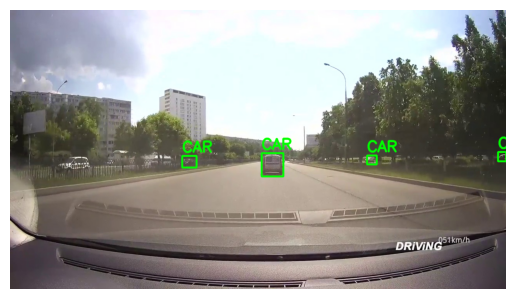

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (41).jpg: 640x576 4 trucks, 2 vans, 5843.8ms
Speed: 9.6ms preprocess, 5843.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (41).jpg: 640x576 1 toto, 4081.8ms
Speed: 3.5ms preprocess, 4081.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)
truck [[465.772216796875, 268.75543212890625, 719.5692749023438, 390.708740234375, 0.5173831582069397], [0.0, 243.2010040283203, 280.0836486816406, 479.8247985839844, 0.48507770895957947], [468.3518981933594, 273.8970642089844, 652.5382080078125, 387.1655578613281, 0.42924991250038147]]
van [[0.7209548950195312, 245.58697509765625, 277.816650390625, 478.47857666015625, 0.3396720290184021], [247.93492126464844, 265.3514709472656, 449.9212341308594, 417.0496520996094, 0.28877148032188416]]
toto [[623.435302734375, 278.0423889160156, 718.6889038085938, 358.13

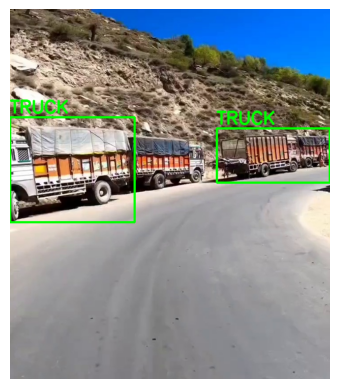

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (19).jpg: 384x640 10 cars, 1 bus, 2720.8ms
Speed: 2.9ms preprocess, 2720.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (19).jpg: 384x640 4 cars, 3438.6ms
Speed: 3.0ms preprocess, 3438.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
car [[645.6856689453125, 362.14141845703125, 730.0814208984375, 447.23760986328125, 0.772398829460144], [737.9027709960938, 378.53466796875, 781.9613647460938, 423.8592529296875, 0.6887375116348267], [752.6929931640625, 357.23809814453125, 790.5550537109375, 385.6878662109375, 0.2855415940284729], [153.8087158203125, 373.8914794921875, 261.88238525390625, 448.24749755859375, 0.2571870982646942]]
bus [[718.8215942382812, 354.8966369628906, 757.5278930664062, 404.9396667480469, 0.25570759177207947]]


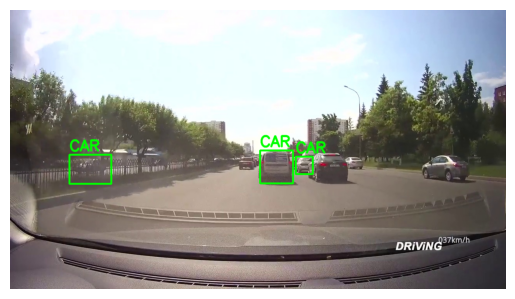

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (48).jpg: 640x576 1 car, 5192.2ms
Speed: 7.1ms preprocess, 5192.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (48).jpg: 640x576 (no detections), 4068.9ms
Speed: 5.3ms preprocess, 4068.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)
car [[206.2810516357422, 394.6357727050781, 265.6338195800781, 438.1103820800781, 0.7175577878952026]]


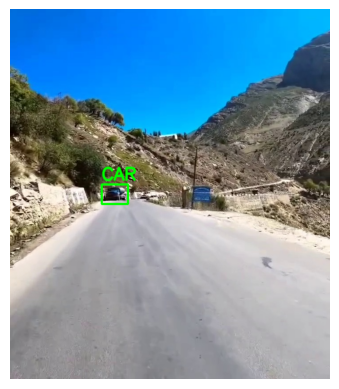

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (43).jpg: 640x576 1 car, 2 bikes, 1 minitruck, 4 trucks, 1 van, 4929.2ms
Speed: 8.2ms preprocess, 4929.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (43).jpg: 640x576 1 car, 1 bike, 1 truck, 2 vans, 5498.1ms
Speed: 4.9ms preprocess, 5498.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)
truck [[133.1153106689453, 318.1806640625, 242.11087036132812, 439.99481201171875, 0.8853832483291626], [65.73310089111328, 330.6761169433594, 151.04794311523438, 470.3201904296875, 0.42426708340644836], [0.036350250244140625, 287.791748046875, 87.17906951904297, 527.9507446289062, 0.4242435693740845], [413.584228515625, 324.1525573730469, 570.409912109375, 450.6755065917969, 0.378238707780838], [66.90764617919922, 333.4433288574219, 147.65289306640625, 463.2917785644531, 0.3607981204986572]]
car [[309.48

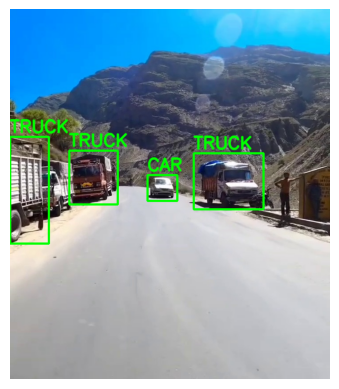

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (45).jpg: 640x576 1 bike, 1 minitruck, 1 truck, 4090.5ms
Speed: 5.0ms preprocess, 4090.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (45).jpg: 640x576 1 bike, 1 truck, 4384.1ms
Speed: 5.5ms preprocess, 4384.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)
bike [[418.8163757324219, 361.06182861328125, 504.6490478515625, 489.2365417480469, 0.81283038854599]]
minitruck [[125.3685073852539, 278.47406005859375, 243.9071044921875, 474.6190185546875, 0.4714846611022949]]
truck [[125.43832397460938, 277.44366455078125, 243.7589569091797, 475.05413818359375, 0.3773902952671051], [0.0, 164.11891174316406, 153.04440307617188, 589.4481811523438, 0.4265473783016205]]


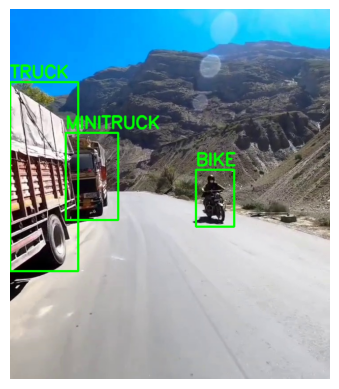

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (44).jpg: 640x576 1 car, 1 bike, 3 trucks, 2 vans, 5843.5ms
Speed: 8.2ms preprocess, 5843.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (44).jpg: 640x576 1 car, 1 bike, 1 truck, 2 vans, 5048.4ms
Speed: 5.8ms preprocess, 5048.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)
truck [[108.31729888916016, 301.971923828125, 257.05023193359375, 454.2015686035156, 0.8490481972694397], [0.0, 310.4484558105469, 131.4163818359375, 513.935546875, 0.4410381317138672], [463.4371337890625, 302.7304382324219, 674.454345703125, 467.0904541015625, 0.410612016916275]]
car [[360.4474182128906, 365.0131530761719, 482.330810546875, 473.5379943847656, 0.8213527798652649]]
van [[0.10531158000230789, 307.9831237792969, 132.03143310546875, 513.937744140625, 0.44155487418174744], [466.7322998046875, 319.845581054

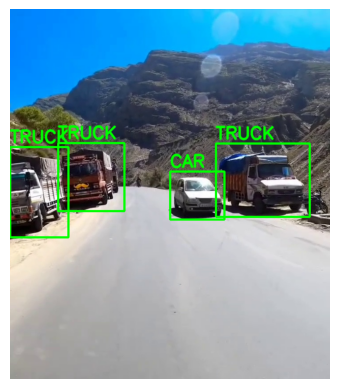

0

image 1/1 /content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/sunnayday1 (33).jpg: 384x640 11 cars, 1 bus, 2 minitrucks, 2843.6ms
Speed: 2.8ms preprocess, 2843.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



KeyboardInterrupt: 

In [28]:
directory = "/content/drive/MyDrive/juvdv2-vdvwc/images/Val/Sunny/Day/"

for filename in os.listdir(directory):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        filepath = os.path.join(directory, filename)
        test = ImageClassifierDetector(models, filepath, threshold=0)
        test.run()